# DATA

Provided data description

**1.** olist_customers_datase.csv — **Unique users IDs**   

| Field | Description |
| :--- | :--- |
| customer_id | User ID for each order |
| customer_unique_id | Unique user ID (like passport number) |
| customer_zip_code_prefix | Postal code |
| customer_city | City of shipment destination |
| customer_state | State of shipment destination | 

**2.** olist_order_items_dataset.csv —  **Products**

| Field | Description |
| :--- | :--- |
| order_id | Unique ID  of the order |
| order_item_id | ID of item in one order |
| product_id | Product ID |
| seller_id | Supplier ID |
| shipping_limit_date | Maximum amount of time to provide the shipment to the delivery service |
| price | Price of item |
| freight_value | Weight of item |

**3.** olist_orders_dataset.csv —  **Orders**  

| Field | Description |
| :--- | :--- |
| order_id | Unique ID  of the order |
| customer_id | User ID for each order |
| order_status | Order status |
| order_purchase_timestamp | Order creation timestamp |
| order_approved_at | Timestamp of transfering order to logistics |
| order_delivered_carrier_date | Maximum amount of time to provide the shipment to the client |
| order_delivered_customer_date | Real order delivery time |
| order_estimated_delivery_date | Estimated order delivery time  |  

**Unique order statuses** olist_orders_dataset table:
* created
* approved
* invoiced
* processing
* shipped
* delivered
* unavailable
* canceled

In [1]:
%%html
<!-- Moving tables to the right -->
<style>table {float:left}</style> 

# Modules

In [2]:
# Data extraction
import requests
import urllib
import json

# Data analysis
import pandas as pd
import numpy as np

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Additional module for RFM
from rfm_secondary_funcs import scorer, segmenter

# Seaborn 'by default' settings for this doc

In [3]:
plot_params = {'figure.titlesize': 22,
               'axes.titlesize': 22,
               'axes.labelsize': 14,
               'axes.titlepad': 20,
               'legend.fontsize': 18,
               'legend.title_fontsize': 18                                   
              }

sns.set_theme(style="whitegrid", palette="RdYlBu_r", rc=plot_params)

# Data extraction

In [4]:
# Public disk storage URL
yandex_api = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

# Exact download requests URLs for an API will be stored here
data_download_urls = []

# Tables URLs
olist_customers_datase_url    = 'https://disk.yandex.ru/d/FUi5uSd6BfG_ig'
olist_orders_dataset_url      = 'https://disk.yandex.ru/d/t9Li4JOfgxuUrg'
olist_order_items_dataset_url = 'https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw'

disk_urls = [olist_customers_datase_url, olist_orders_dataset_url, olist_order_items_dataset_url]

In [5]:
# Filling the list 
for disk_url in disk_urls:
    # Creating request for an API
    url = yandex_api + urllib.parse.urlencode(dict(public_key=disk_url))        
    
    # Request and get data link 
    r = requests.get(url)
    h = json.loads(r.text)['href']
    
    # Appending the list
    data_download_urls.append(h)

In [6]:
# Consuming we already know the fields, that contain dates, we will try to parse them on read.
date_fields = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
               'order_delivered_customer_date', 'order_estimated_delivery_date']


# Создаем датафреймы из полученных ссылок. Сразу парсим даты в удобный формат данных.
users    = pd.read_csv(data_download_urls[0], sep=',')
orders   = pd.read_csv(data_download_urls[1], sep=',', parse_dates=date_fields)
products = pd.read_csv(data_download_urls[2], sep=',', parse_dates=['shipping_limit_date'])

# Pre-processing

###  Our main goal in this report is to do couple insights based on client orders. Regarding this we should first of all decide what we will count as a successfull order.

##### Preliminary plan.
Order is successful when:
- order_approved_at - not null. This means that we have recived and approved the payment.  
и
- order_status - not unavailable and not canceled. This means that item could be supplied and order was not canceled

Let's join the users and orders data

In [7]:
users_orders = users.merge(orders, on='customer_id')

Brief data review

In [8]:
print(f'Unique orders total amount: {users_orders.order_id.nunique()} шт.')
print(f'Unique clients total amount: {users_orders.customer_unique_id.nunique()} человек\n')

print(f'Earliest date of an order approval in provided data: {users_orders.order_approved_at.min()}')
print(f'Latest date of an order approval in provided data: {users_orders.order_approved_at.max()}\n')

print('Distribution of orders by status:')
print(orders.order_status.value_counts())

Unique orders total amount: 99441 шт.
Unique clients total amount: 96096 человек

Earliest date of an order approval in provided data: 2016-09-15 12:16:38
Latest date of an order approval in provided data: 2018-09-03 17:40:06

Distribution of orders by status:
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64


Let's take a look at orders that was  
- paid by client  
- not received by client
- with status **'canceled'**

In [9]:
(users_orders[users_orders.order_delivered_customer_date.isnull() & ~users_orders.order_approved_at.isnull()]
 .query('order_status == "canceled"')).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 46 to 99178
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    478 non-null    object        
 1   customer_unique_id             478 non-null    object        
 2   customer_zip_code_prefix       478 non-null    int64         
 3   customer_city                  478 non-null    object        
 4   customer_state                 478 non-null    object        
 5   order_id                       478 non-null    object        
 6   order_status                   478 non-null    object        
 7   order_purchase_timestamp       478 non-null    datetime64[ns]
 8   order_approved_at              478 non-null    datetime64[ns]
 9   order_delivered_carrier_date   69 non-null     datetime64[ns]
 10  order_delivered_customer_date  0 non-null      datetime64[ns]
 11  order_estimated_

There are 478 such orders, 69 of them was trsspased to the carrier

We can also find **'canceled'** orders with statuses: payment approval, at carrier and even already delivered 

In [10]:
users_orders.query('order_status == "canceled"').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 625 entries, 46 to 99178
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    625 non-null    object        
 1   customer_unique_id             625 non-null    object        
 2   customer_zip_code_prefix       625 non-null    int64         
 3   customer_city                  625 non-null    object        
 4   customer_state                 625 non-null    object        
 5   order_id                       625 non-null    object        
 6   order_status                   625 non-null    object        
 7   order_purchase_timestamp       625 non-null    datetime64[ns]
 8   order_approved_at              484 non-null    datetime64[ns]
 9   order_delivered_carrier_date   75 non-null     datetime64[ns]
 10  order_delivered_customer_date  6 non-null      datetime64[ns]
 11  order_estimated_

Consuming information above let's count orders as successful only when their status is not canceled.  
Those of canceled orders that was delivered customers should not be read as successful, because the money will be refund.  
Regarding this let's create a dataframe of successful purchases

In [11]:
purchases = users_orders.query('order_status != "canceled"')

Now let's take a look at **'unavailable'** orders:

In [12]:
purchases.query('order_status == "unavailable"').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 609 entries, 288 to 99105
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    609 non-null    object        
 1   customer_unique_id             609 non-null    object        
 2   customer_zip_code_prefix       609 non-null    int64         
 3   customer_city                  609 non-null    object        
 4   customer_state                 609 non-null    object        
 5   order_id                       609 non-null    object        
 6   order_status                   609 non-null    object        
 7   order_purchase_timestamp       609 non-null    datetime64[ns]
 8   order_approved_at              609 non-null    datetime64[ns]
 9   order_delivered_carrier_date   0 non-null      datetime64[ns]
 10  order_delivered_customer_date  0 non-null      datetime64[ns]
 11  order_estimated

Unavailable orders was neither passed to the carrier or supplied to the customer.  
However, the payment was approved for all of those orders.  
Nevertheless, we can not count them as successful because the products can not be supplied.

In [13]:
purchases = purchases.query('order_status != "unavailable"')

Obviously, new orders with status **'created'** are not successfull as well.  
There is no approved orders having this status anyway:

In [14]:
purchases.query('order_status == "created"').order_approved_at.unique()

array(['NaT'], dtype='datetime64[ns]')

Let's exclude those orders from our purchases DF

In [15]:
purchases = purchases.query('order_status != "created"')

At this stage our purchases looks like this:  

In [16]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98202 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    98202 non-null  object        
 1   customer_unique_id             98202 non-null  object        
 2   customer_zip_code_prefix       98202 non-null  int64         
 3   customer_city                  98202 non-null  object        
 4   customer_state                 98202 non-null  object        
 5   order_id                       98202 non-null  object        
 6   order_status                   98202 non-null  object        
 7   order_purchase_timestamp       98202 non-null  datetime64[ns]
 8   order_approved_at              98188 non-null  datetime64[ns]
 9   order_delivered_carrier_date   97583 non-null  datetime64[ns]
 10  order_delivered_customer_date  96470 non-null  datetime64[ns]
 11  order_estimated

We still have an orders with no approval date, carrier date or client date.  
Let's exclude orders without approval date.

In [17]:
purchases = purchases[~purchases.order_approved_at.isnull()]

Now we have a **purchases** DF, **the orders it contains will be counted as successful**.  

In [18]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98188 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    98188 non-null  object        
 1   customer_unique_id             98188 non-null  object        
 2   customer_zip_code_prefix       98188 non-null  int64         
 3   customer_city                  98188 non-null  object        
 4   customer_state                 98188 non-null  object        
 5   order_id                       98188 non-null  object        
 6   order_status                   98188 non-null  object        
 7   order_purchase_timestamp       98188 non-null  datetime64[ns]
 8   order_approved_at              98188 non-null  datetime64[ns]
 9   order_delivered_carrier_date   97569 non-null  datetime64[ns]
 10  order_delivered_customer_date  96456 non-null  datetime64[ns]
 11  order_estimated

### Pre-processing order<->product data

Let's take a look at orders which date of delivery is unavailable while status is 'delivered'

In [19]:
orders[orders.order_delivered_customer_date.isnull()].query('order_status == "delivered"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


We can see a discrepancy in fields 'status' and 'date of this status'.  
We have 8 orders with delivered status, but without date of delivery.  
One of them even was not passed to the carrier

In this report we will count **'order_status'** more important than **'order_delivered_customer_date'**.  

This means, if the order have status 'delivered', than it is realy delivered. The date of delivery was not provided because of an internal system error.

Let's join **products** and **orders** data.

In [20]:
orders_products = orders.merge(products, on='order_id', how='right')

For the rows with empty 'carrier date' we will use maximum carrier date

In [21]:
orders_products.loc[
    (orders_products.order_delivered_customer_date.isnull()) &     
    (orders_products.order_delivered_carrier_date.isnull()) &
    (orders_products.order_status == 'delivered'), 
    'order_delivered_carrier_date'] = orders_products.shipping_limit_date

For the empty delivery date we will use mean delivery time

In [22]:
mean_delivery_time = (orders_products['order_delivered_customer_date'] - 
                      orders_products['order_delivered_carrier_date']).mean()

Filling the customer delivery dates

In [23]:
orders_products.loc[
    (orders_products.order_delivered_customer_date.isnull()) &        
    (orders_products.order_status == 'delivered'), 
    'order_delivered_customer_date'] = orders_products.order_delivered_carrier_date + mean_delivery_time

Now we have a **orders_products** DF,which contains data about orders and products relationships

In [24]:
orders_products.query('order_status == "delivered"').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110197 entries, 0 to 112649
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110197 non-null  object        
 1   customer_id                    110197 non-null  object        
 2   order_status                   110197 non-null  object        
 3   order_purchase_timestamp       110197 non-null  datetime64[ns]
 4   order_approved_at              110182 non-null  datetime64[ns]
 5   order_delivered_carrier_date   110196 non-null  datetime64[ns]
 6   order_delivered_customer_date  110197 non-null  datetime64[ns]
 7   order_estimated_delivery_date  110197 non-null  datetime64[ns]
 8   order_item_id                  110197 non-null  int64         
 9   product_id                     110197 non-null  object        
 10  seller_id                      110197 non-null  object        
 11  

Filling the last empty carrier dates

In [25]:
orders_products.loc[(orders_products['order_status'] == "delivered") & 
                    (orders_products.order_delivered_carrier_date.isnull()),
                    'order_delivered_carrier_date'] = orders_products.shipping_limit_date

Thus all delivered orders have dates at all stages of delivery process.  
We are still waitng the payment approval for some of orders, but tht seems ordinary.  

In [26]:
orders_products.query('order_status == "delivered"').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110197 entries, 0 to 112649
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110197 non-null  object        
 1   customer_id                    110197 non-null  object        
 2   order_status                   110197 non-null  object        
 3   order_purchase_timestamp       110197 non-null  datetime64[ns]
 4   order_approved_at              110182 non-null  datetime64[ns]
 5   order_delivered_carrier_date   110197 non-null  datetime64[ns]
 6   order_delivered_customer_date  110197 non-null  datetime64[ns]
 7   order_estimated_delivery_date  110197 non-null  datetime64[ns]
 8   order_item_id                  110197 non-null  int64         
 9   product_id                     110197 non-null  object        
 10  seller_id                      110197 non-null  object        
 11  

Pre-processing is finished. Let's move on to the tasks.

### 1 How many users made a purchase only once?

Group by unique users and count their orders. 

In [27]:
users_purchases = (purchases
                   .groupby('customer_unique_id', as_index=False)
                   .agg(purchases_amount=('customer_id', 'count'))
                   .purchases_amount.value_counts()
                   .rename_axis('purchases_count').reset_index(name='purchases_amount')
                  )

In [28]:
users_purchases.head()

,purchases_count,purchases_amount
0,1,92087
1,2,2650
2,3,188
3,4,29
4,5,9


Let's visualize the data

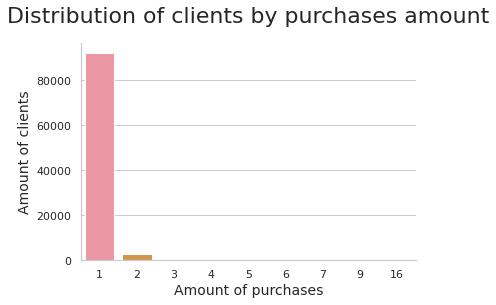

In [29]:
sns.barplot(data=users_purchases, x='purchases_count', y='purchases_amount')
            
plt.xlabel('Amount of purchases')
plt.ylabel('Amount of clients')
plt.title('Distribution of clients by purchases amount')

sns.despine()
plt.show()

The vast majority of clients made only one purchase.  
Observable amount of clients made two purchases.  
Anyway the viz above could not be interpreted normaly because the distribution is highly skewed.  
Let's apply logartihm

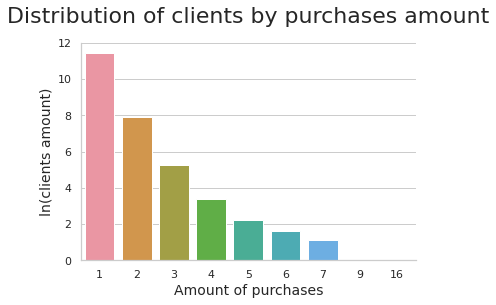

In [30]:
users_purchases['purchases_amount_ln'] = np.log(users_purchases['purchases_amount'])

sns.barplot(data=users_purchases, x='purchases_count', y='purchases_amount_ln')            

plt.xlabel('Amount of purchases')
plt.ylabel('ln(clients amount)')
plt.title('Distribution of clients by purchases amount')

sns.despine()
plt.show()

From a logical point of view, the distribution looks reasonable.  
Less clients makes more orders.

In response to this unit's question

In [31]:
one_purchase_users = users_purchases.loc[users_purchases.purchases_count == 1, 'purchases_amount'].values[0]
print(f'{one_purchase_users} users made only one purchase.')

92087 users made only one purchase.


### 2  What is a mean amount of products that are not delivered monthly?

We will use the pre-proccessed data, excluding orders with status **'delivered'**.   

As discussed before, we count all orders with status 'delivered' as truly delivered.

In [32]:
undelivered_products = orders_products.query('order_status != "delivered"')

In [33]:
undelivered_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2453 entries, 79 to 112421
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       2453 non-null   object        
 1   customer_id                    2453 non-null   object        
 2   order_status                   2453 non-null   object        
 3   order_purchase_timestamp       2453 non-null   datetime64[ns]
 4   order_approved_at              2453 non-null   datetime64[ns]
 5   order_delivered_carrier_date   1261 non-null   datetime64[ns]
 6   order_delivered_customer_date  7 non-null      datetime64[ns]
 7   order_estimated_delivery_date  2453 non-null   datetime64[ns]
 8   order_item_id                  2453 non-null   int64         
 9   product_id                     2453 non-null   object        
 10  seller_id                      2453 non-null   object        
 11  shipping_limit

We can find 7 orders, which have delivery date, despite we have excluded delivered.  
Let's check their status.

In [34]:
undelivered_products[~undelivered_products.order_delivered_customer_date.isnull()].order_status.unique()

array(['canceled'], dtype=object)

Ok, we have orders which was canceled after being delivered to the client.  
We will exclude theese rows from 'undelivered' group, because they were delivered anyway.

In [35]:
undelivered_products = undelivered_products[undelivered_products.order_delivered_customer_date.isnull()]

Now let's check statuses of the products that was not passed to the carrier

In [36]:
undelivered_products[undelivered_products.order_delivered_carrier_date.isnull()].order_status.unique()

array(['canceled', 'invoiced', 'processing', 'approved', 'unavailable'],
      dtype=object)

I general, theese orders statuses are corresponding to the sales pipeline. No corrections required.

Let's analyze the resons of 'undelivery'.  
We are interested in monthly statistics, so we should conver the date to YYYY-MM format.

In [37]:
undelivered_products.loc[:,'order_estimated_delivery_date'] \
= pd.DatetimeIndex(undelivered_products['order_estimated_delivery_date']).to_period('M')

undelivered_products_status = (undelivered_products
                               .groupby(['order_estimated_delivery_date', 'order_status'], as_index=False)
                               .agg(undelivered_amount=('order_id', 'count'))
                              )

In [38]:
undelivered_products_status.head()

,order_estimated_delivery_date,order_status,undelivered_amount
0,2016-10,canceled,2
1,2016-10,shipped,2
2,2016-11,canceled,1
3,2016-11,invoiced,10
4,2016-11,shipped,1


Counting mean amount of 'undelivered' products by month.

In [39]:
mean_undelivered = (undelivered_products_status
                    .groupby('order_status', as_index=False) 
                    .agg(mean_undelivered_orders=('undelivered_amount', 'mean'))
                    .sort_values(by='mean_undelivered_orders', ascending=False)
                    .round(3)
                   )
mean_undelivered.head(5)

,order_status,mean_undelivered_orders
4,shipped,51.522
1,canceled,24.318
3,processing,18.789
2,invoiced,17.095
5,unavailable,3.500


Adding visualisation

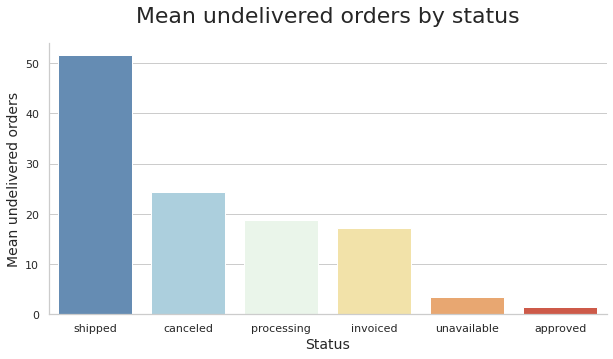

In [40]:
plt.figure(figsize=(10, 5))

sns.barplot(data=mean_undelivered, x='order_status', y='mean_undelivered_orders')

plt.xlabel('Status')
plt.ylabel('Mean undelivered orders')
plt.title('Mean undelivered orders by status')

sns.despine()
plt.show()

Monthly dinamycs of undelivery by month

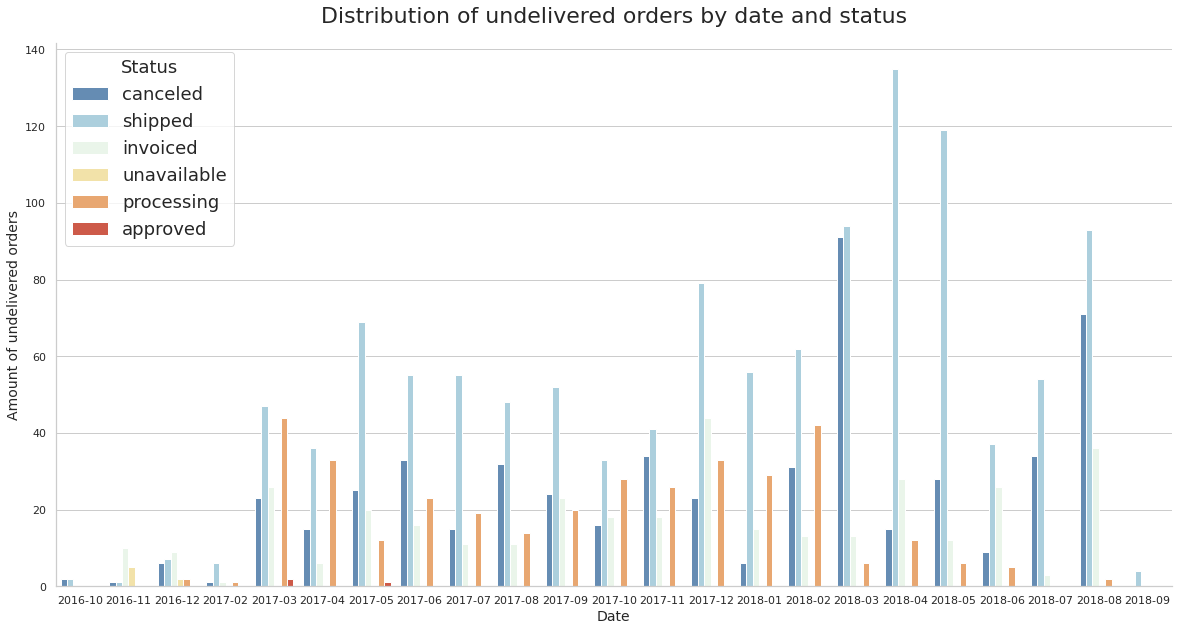

In [41]:
plt.figure(figsize=(20, 10))

sns.barplot(data=undelivered_products_status, 
            x='order_estimated_delivery_date',
            y='undelivered_amount',
            hue='order_status'
           )

plt.xlabel('Date')
plt.ylabel('Amount of undelivered orders')
plt.title('Distribution of undelivered orders by date and status')
plt.legend(title='Status', loc='upper left')

sns.despine()
plt.show()

Most of the undelivered orders are either on their way to the client or was canceled. Very small amount are on pre-sale stages.  
Thus, we can make a conclusion that our orders processing system works good. Much faster than logistics.  
We can also see that very few products are unavailable to order. This is a sign that our stock works great as well.

Response to this unit's question

In [42]:
undelivered_amount_mean = mean_undelivered.mean_undelivered_orders.mean()

print(f'{int(undelivered_amount_mean)} products are being undelivered monthly.')

19 products are being undelivered monthly.


### 3  The most popular day of week to buy each product

We will use pre-processed products data. It should be joined with purchases data.  
**'order_purchase_timestamp'** will be counted as date of purchase

In [43]:
products_purchases = purchases.merge(products, on='order_id')

Adding day of week for purchases data. Also adding weekday number 1-7, to simplify sorting.

In [44]:
products_purchases.loc[:,'purchase_weekday']      = products_purchases.order_purchase_timestamp.dt.dayofweek + 1
products_purchases.loc[:,'purchase_weekday_name'] = products_purchases.order_purchase_timestamp.dt.day_name()

Grouping by product ID an day of week.  
Counting amount of products for each day of week.  
For each product keeping only the most popular weekday name.

In [45]:
weekday_product_purchases = (products_purchases
                             .groupby(['product_id', 'purchase_weekday', 'purchase_weekday_name'], as_index=False)
                             .agg(ordered_amount=('order_id', 'count'))
                             .sort_values(by='ordered_amount', ascending=False)
                             .drop_duplicates(subset='product_id', keep='first')
                            )
weekday_product_purchases.head(5)

,product_id,purchase_weekday,purchase_weekday_name,ordered_amount
15808,422879e10f46682990de24d770e7f83d,3,Wednesday,93
36304,99a4788cb24856965c36a24e339b6058,1,Monday,92
40818,aca2eb7d00ea1a7b8ebd4e68314663af,4,Thursday,89
20005,53b36df67ebb7c41585e8d54d6772e08,2,Tuesday,76
12933,368c6c730842d78016ad823897a372db,5,Friday,67


In [46]:
print(f'We have {weekday_product_purchases.product_id.nunique()} unique products.')

We have 32726 unique products.


There are a lot of such products. Let's take a look at mean and total amount of orders by weekday.

In [47]:
weekday_purchases = (products_purchases
                     .groupby(['product_id', 'purchase_weekday_name', 'purchase_weekday'], as_index=False)
                     .agg(ordered_amount=('order_item_id', 'count'))                                          
                     .groupby(['purchase_weekday_name', 'purchase_weekday'], as_index=False)
                     .agg(ordered_mean=('ordered_amount', 'mean'), ordered_total=('ordered_amount', 'sum'))
                     .sort_values(by='purchase_weekday')
                    )

Visualizing

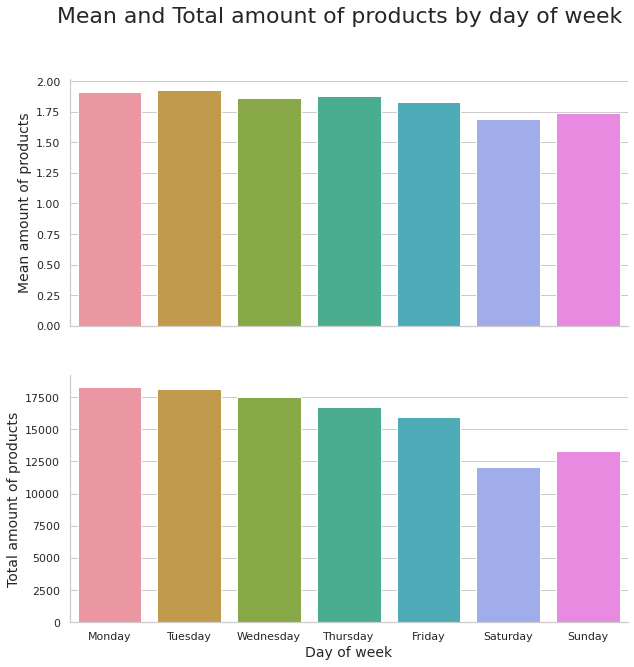

In [48]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

sns.barplot(data=weekday_purchases, x='purchase_weekday_name', y='ordered_mean', ax=ax1)          
sns.barplot(data=weekday_purchases, x='purchase_weekday_name', y='ordered_total', ax=ax2)

ax1.set_xlabel('')
ax1.set_ylabel('Mean amount of products')

ax2.set_xlabel('Day of week')
ax2.set_ylabel('Total amount of products')

plt.suptitle('Mean and Total amount of products by day of week')

sns.despine()
plt.show()

Mean amount of products by day of week is 2.  
Most purchases were done at the start of the week, least at weekends.

### 4  Mean amount of purchases for each user by week(monthly)

We will use pre-processed products data.  
**'order_purchase_timestamp'** will be counted as date of purchase

Adding week and month columns for each purchase.

In [49]:
purchases['week']  = purchases.order_purchase_timestamp.dt.isocalendar().week
purchases['month'] = pd.DatetimeIndex(purchases['order_purchase_timestamp']).to_period('M')

Keeping only necessary columns to count mean amount of purchases.

In [50]:
purchases_by_week = purchases[['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'week', 'month']]

Brief preview

In [51]:
unique_customers = purchases_by_week.customer_unique_id.nunique()
orders_amount    = purchases_by_week.shape[0]

print(f'{unique_customers} clients made {orders_amount} purchases.')

94973 clients made 98188 purchases.


Grouping up the data by users and purchase monthes.  
Counting the amount of purchases. 

In [52]:
mean_purchases_by_week = (purchases_by_week
                          .groupby(['customer_unique_id', 'month'], as_index=False)
                          .agg(orders_amount=('order_id', 'count'))                          
                         )

For each client counting for the number of the weeks in that month.

In [53]:
# Amount of weeks for the particular month
weeks = (mean_purchases_by_week.month.dt.daysinmonth / 7) 
mean_purchases_by_week['mean_orders_weekly'] = (mean_purchases_by_week.orders_amount / weeks).round(3)

Checking that we didn't lost any clients

In [54]:
if mean_purchases_by_week.customer_unique_id.nunique() == unique_customers:
    print('Ok')
else:
    print('Not ok, we have lost some clients!')  

Ok


Now we can count the mean amount of purchases by week(monthly)

In [55]:
mean_purchases_by_week[['customer_unique_id', 'mean_orders_weekly']].head()

,customer_unique_id,mean_orders_weekly
0,0000366f3b9a7992bf8c76cfdf3221e2,0.226
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.226
2,0000f46a3911fa3c0805444483337064,0.226
3,0000f6ccb0745a6a4b88665a16c9f078,0.226
4,0004aac84e0df4da2b147fca70cf8255,0.233


The viz of the data could not be interpreted normaly because the distribution is highly skewed.  
Let's apply logartihm

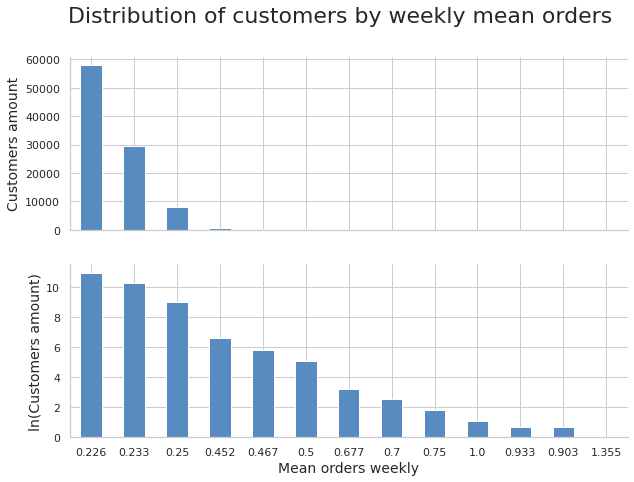

In [56]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,7))

mean_purchases_by_week.mean_orders_weekly.value_counts().plot.bar(rot=0, ax=ax1)
np.log(mean_purchases_by_week.mean_orders_weekly.value_counts()).plot.bar(rot=0, ax=ax2)

plt.xlabel('Mean orders weekly')
ax1.set_ylabel('Customers amount')
ax2.set_ylabel('ln(Customers amount)')

plt.suptitle('Distribution of customers by weekly mean orders')

sns.despine()
plt.show()

Most users mean amount of purchases by week (monthly) is 1.  
This is consistent with previous data, as we know that most customers made only one purchase.  
*There are 4..4.3 weeks in month => (1 purchase) / (4..4.3 weeks) ~= 0.23-0.25*

Nevertheless, there is also a significant part of clients whose mean amount of purchases by week (monthly) is 2.  
*Average orders == 0.45*. 

And even those who made more than 2 purchases, but there are very few of them within the data.

### 5  Cohort analysis.  
### Searching for the cohort with the biggest retention on 3rd month in a period January-December

For the date of the first purchase (**Month 0**) we will use **'order_purchase_timestamp'**.

In [57]:
cohorts = purchases[['month', 'customer_unique_id', 'order_id', ]]

In [58]:
print(f'We have {cohorts.customer_unique_id.nunique()} unique clients.')

We have 94973 unique clients.


Let's take a look at the dateperiod provided in the data.

In [59]:
sorted(cohorts.month.unique())

[Period('2016-09', 'M'),
 Period('2016-10', 'M'),
 Period('2016-12', 'M'),
 Period('2017-01', 'M'),
 Period('2017-02', 'M'),
 Period('2017-03', 'M'),
 Period('2017-04', 'M'),
 Period('2017-05', 'M'),
 Period('2017-06', 'M'),
 Period('2017-07', 'M'),
 Period('2017-08', 'M'),
 Period('2017-09', 'M'),
 Period('2017-10', 'M'),
 Period('2017-11', 'M'),
 Period('2017-12', 'M'),
 Period('2018-01', 'M'),
 Period('2018-02', 'M'),
 Period('2018-03', 'M'),
 Period('2018-04', 'M'),
 Period('2018-05', 'M'),
 Period('2018-06', 'M'),
 Period('2018-07', 'M'),
 Period('2018-08', 'M'),
 Period('2018-09', 'M')]

The only year, that contain data from Jan to Dec is 2017

In [60]:
cohorts = cohorts.query('(month >= "2017-01") & (month <= "2017-12")')

Counting Month 0 for each client

In [61]:
month_0_customers = cohorts.groupby('customer_unique_id', as_index=False).agg(month_0 = ('month', 'min'))

In [62]:
month_0_customers.head()

,customer_unique_id,month_0
0,0000f46a3911fa3c0805444483337064,2017-03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10
2,0004aac84e0df4da2b147fca70cf8255,2017-11
3,0005e1862207bf6ccc02e4228effd9a0,2017-03
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07


Merging month_0 information with cohorts DF.

In [63]:
cohorts = cohorts.merge(month_0_customers, how='left')

Counting the time difference from the first purchase to the other

In [64]:
cohorts['cohort_period'] = cohorts.month.view(dtype='int64') - cohorts.month_0.view(dtype='int64')

Counting unique clients for each cohort

In [65]:
cohort_df = (cohorts
             .groupby(['cohort_period','month_0'], as_index=False)
             .agg(uniq_customers=('customer_unique_id', 'nunique'))
             .reset_index()             
             .rename(columns={'month_0': 'cohort'})
             .pivot(index='cohort', columns='cohort_period', values='uniq_customers')
            )

Calculating **retention**.

In [66]:
retention = cohort_df.divide(cohort_df.iloc[:,0], axis = 0).round(5)

Adding style to simplify interpritation.  Convert **retention** to percent. Painting NaN in white.

In [67]:
(retention
 .style
 .set_caption('Customers retention by cohort') 
 .background_gradient(cmap='RdYlBu_r')
 .highlight_null('white')
 .format("{:.3%}", na_rep="")
)

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,100.000%,0.399%,0.266%,0.133%,0.399%,0.133%,0.399%,0.133%,0.133%,,0.399%,0.133%
2017-02,100.000%,0.238%,0.298%,0.119%,0.417%,0.119%,0.238%,0.179%,0.060%,0.179%,0.119%,
2017-03,100.000%,0.506%,0.350%,0.389%,0.350%,0.156%,0.156%,0.311%,0.350%,0.078%,,
2017-04,100.000%,0.602%,0.215%,0.172%,0.301%,0.258%,0.344%,0.301%,0.301%,,,
2017-05,100.000%,0.480%,0.480%,0.395%,0.311%,0.339%,0.424%,0.141%,,,,
2017-06,100.000%,0.451%,0.355%,0.387%,0.258%,0.387%,0.355%,,,,,
2017-07,100.000%,0.523%,0.340%,0.235%,0.288%,0.209%,,,,,,
2017-08,100.000%,0.678%,0.339%,0.266%,0.363%,,,,,,,
2017-09,100.000%,0.687%,0.540%,0.294%,,,,,,,,


In [68]:
cohort_period = 3 # 3rd month

print('Cohort with the highest retention on 3rd month:', retention.loc[:, cohort_period].idxmax())

Cohort with the highest retention on 3rd month: 2017-05


### 6  RFM-analysis 

To calculate M(Monetary) we will use **purchases** DF merged with products and orders data

In [69]:
products_purchases = purchases.merge(orders_products, on='order_id', how='left')

Keeping only neccessary columns

In [70]:
products_purchases = products_purchases[['order_id', 'order_purchase_timestamp_x', 'customer_id_x', 'customer_unique_id',
                                         'order_status_y', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
                                         'price', 'freight_value', 'order_approved_at_x']]

products_purchases.rename(columns={'order_purchase_timestamp_x': 'order_purchase_timestamp',
                                   'customer_id_x': 'customer_id',
                                   'order_status_y': 'order_status', 
                                   'order_approved_at_x': 'order_approved_at'},
                          inplace=True)


Checkin orders earlies and latest dates.

In [71]:
oldest_order = products_purchases.order_purchase_timestamp.min()
newest_order = products_purchases.order_purchase_timestamp.max()

print(f'First order: {oldest_order}.\nLatest order: {newest_order}')

First order: 2016-09-04 21:15:19.
Latest order: 2018-09-03 09:06:57


We will use a period of one year. Only year 2017 in provided data contains such time difference

In [72]:
products_purchases = products_purchases.query('(order_purchase_timestamp >= "2017-01") &\
                                               (order_purchase_timestamp < "2018-01")')

In [73]:
oldest_order = products_purchases.order_purchase_timestamp.min().date()
newest_order = products_purchases.order_purchase_timestamp.max().date()

print(f'Analyzing period: from {oldest_order} till {newest_order}.')

Analyzing period: from 2017-01-05 till 2017-12-31.


In [74]:
rfm_today = products_purchases.order_purchase_timestamp.max() + pd.Timedelta(10, "d")

Adding the column with days from last purches to our DF.

In [75]:
products_purchases['days_since_order'] = (rfm_today - products_purchases['order_approved_at']).dt.days

In [76]:
products_purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50602 entries, 0 to 112088
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  50602 non-null  object        
 1   order_purchase_timestamp  50602 non-null  datetime64[ns]
 2   customer_id               50602 non-null  object        
 3   customer_unique_id        50602 non-null  object        
 4   order_status              50602 non-null  object        
 5   order_item_id             50602 non-null  float64       
 6   product_id                50602 non-null  object        
 7   seller_id                 50602 non-null  object        
 8   shipping_limit_date       50602 non-null  datetime64[ns]
 9   price                     50602 non-null  float64       
 10  freight_value             50602 non-null  float64       
 11  order_approved_at         50602 non-null  datetime64[ns]
 12  days_since_order 

In [77]:
products_purchases.head(5)

,order_id,order_purchase_timestamp,customer_id,customer_unique_id,order_status,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_approved_at,days_since_order
0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,delivered,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,2017-05-16 15:22:12,239
5,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:14:31,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,delivered,1.0,0be701e03657109a8a4d5168122777fb,8f2ce03f928b567e3d56181ae20ae952,2017-09-20 18:25:11,259.90,22.31,2017-09-14 18:25:11,118
7,1093c8304c7a003280dd34598194913d,2017-11-16 19:29:02,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,delivered,1.0,124f74f703e88efe001a10bfa718b6ff,2a7dc43cecabf23403078e2188437d1d,2017-11-22 19:55:41,19.90,16.11,2017-11-16 19:55:41,55
10,8428e578bb1cf839ae26a6b7615502b9,2017-11-27 17:23:20,9fb35e4ed6f0a14a4977cd9aea4042bb,2a7745e1ed516b289ed9b29c7d0539a5,delivered,1.0,6b874ff4c71d18e91079b40396bf176a,b6e1504972665f739dec4facb9943775,2017-12-01 18:01:20,25.30,15.10,2017-11-27 18:01:20,44
12,83d8f70418eefd96f37b483dff430305,2017-09-09 09:54:57,b2d1536598b73a9abd18e0d75d92f0a3,918dc87cd72cd9f6ed4bd442ed785235,delivered,1.0,3fc00af0f0a8d4ac2933d3900416c977,7a241947449cc45dbfda4f9d0798d9d0,2017-09-14 10:10:17,99.00,18.31,2017-09-09 10:10:17,123


In [78]:
uniq_customers = products_purchases.customer_unique_id.nunique()
uniq_orders    = products_purchases.order_id.nunique()

print(f'{uniq_customers} unique clients made {uniq_orders} orders.')

43017 unique clients made 44361 orders.


Calculating **Recency** and **Frequency**.

For implementing the RFM approach, we need to get one row per customer over a period of one year (365 days).  
To do this, we will group the data by customers.  
**Recency**   - the minimum of the number of time difference from the last order for each client.  
**Frequency** - the number of orders for the reviewed period.

In [79]:
rfm = (products_purchases
       .groupby('customer_unique_id', as_index=False)
       .agg(Recency=('days_since_order', 'min'), Frequency=('order_id', 'count'))
      )

Now we need to add the **Monetary** metric for each unique client.  

Even though **'price'** is the item price in the data description, we have absolutely no data about the quantity of the items in the orders.  
Therefore, we will assume that in fact this is the total cost of the position in the order.

In [80]:
customers_monetary = (products_purchases
                      .groupby('customer_unique_id', as_index=False)
                      .agg(Monetary=('price', 'sum'))
                     )

Adding R, F, M to the data.

In [81]:
rfm = rfm.merge(customers_monetary, on='customer_unique_id')
rfm.describe()

,Recency,Frequency,Monetary
count,43017.000000,43017.000000,43017.000000
mean,146.400353,1.176326,141.962988
std,95.550014,0.600461,223.837474
min,6.000000,1.000000,2.290000
25%,56.000000,1.000000,47.990000
50%,132.000000,1.000000,89.000000
75%,222.000000,1.000000,155.000000
max,370.000000,21.000000,13440.000000


In [82]:
rfm.head(5)

,customer_unique_id,Recency,Frequency,Monetary
0,0000f46a3911fa3c0805444483337064,306,1,69.00
1,0000f6ccb0745a6a4b88665a16c9f078,90,1,25.99
2,0004aac84e0df4da2b147fca70cf8255,57,1,180.00
3,0005e1862207bf6ccc02e4228effd9a0,311,1,135.00
4,0006fdc98a402fceb4eb0ee528f6a8d4,176,1,13.90


Declaring variable **metrics** for futher vizes. This variable contains the number of reviewed metrics.

In [83]:
metrics = 3

Plotting the R, F and M distributions

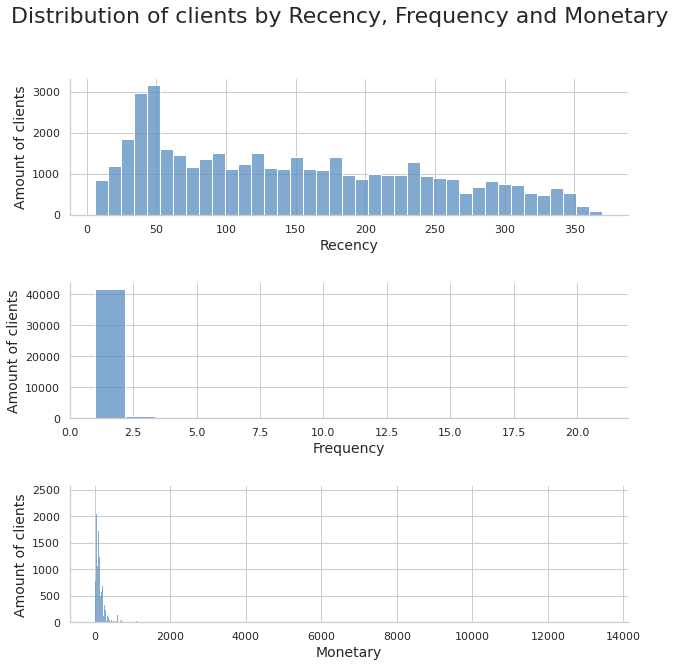

In [84]:
f, axes = plt.subplots(metrics, 1, figsize=(10,10))

for i in range(metrics):   
    ax     = axes[i]
    column = i + 1
    
    sns.histplot(data=rfm[rfm.columns[column]], ax=ax)
    
    ax.set_xlabel(rfm.columns[i+1])
    ax.set_ylabel('Amount of clients') 

plt.suptitle('Distribution of clients by Recency, Frequency and Monetary')
plt.subplots_adjust(hspace=0.5)
sns.despine()
plt.show()

Only **Recency** has a more or less uniform distribution.  
**Frequency** and **Monetary** are heavily skewed to the left.  
Let's start dividing customers into segments with a quantile approach.  
Theoretically, this approach will allow us to apply the algorithm with any new data.

In [85]:
quantiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quantiles

{'Recency': {0.2: 47.0, 0.4: 100.0, 0.6: 165.0, 0.8: 241.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 39.9, 0.4: 68.9, 0.6: 108.57599999999991, 0.8: 179.96}}

Obviously quantile approach will not work for **Frequency** for the provided data

Let's take a closer look at this metrics.

In [86]:
rfm.Frequency.value_counts().head(7)

1    37722
2     4014
3      753
4      309
5      104
6       75
7       12
Name: Frequency, dtype: int64

Based on the data above, the segmentation of the **Frequency** metric seems reasonable into groups by the number of purchased: 1, 2, 3, 4, 5+

In [87]:
q = dict()
for i in range(1,6):
    q[i/5] = float(i)
    
quantiles['Frequency'] = q
quantiles

{'Recency': {0.2: 47.0, 0.4: 100.0, 0.6: 165.0, 0.8: 241.0},
 'Frequency': {0.2: 1.0, 0.4: 2.0, 0.6: 3.0, 0.8: 4.0, 1.0: 5.0},
 'Monetary': {0.2: 39.9, 0.4: 68.9, 0.6: 108.57599999999991, 0.8: 179.96}}

Segments description (5 - best, 1 - worst):  

1. **Recency**:  

    1) 241 days and above   
    2) 165-240 days  
    3) 101-164 days    
    4) 47-100 days    
    5) 0-46 days  
    

2. **Frequency**:  
    
    1) 1 purchase  
    2) 2 purchases  
    3) 3 purchases  
    4) 4 purchases  
    5) 5 purchases and above  
    

3. **Monetary**:  

    1) Purchase amount 0-39.9  
    2) Purchase amount 40-68.9  
    3) Purchase amount 69-108.6  
    4) Purchase amount 109-180  
    5) Purchase amount 180 and above
    

It is important to note that only the **frequency** is set manually and will be evaluated regardless of the dataset.  
The remaining two metrics are calculated based on the provided data.  
Therefore, the description above for these two parameters corresponds only to this dataset.  
They will be adapted as the data changes.

We will use the function prepared for this project to apply R, F and M scores regarding the info above

In [88]:
help(scorer)

Help on function scorer in module rfm_secondary_funcs:

scorer(param, param_name, quantiles)
    Parameters:
        param      - pd.Series contains RFM metric
        param_name - name of RFM metric  
        quantiles  - dict with R, F and M splits
    Returns:
        Score for passed metric, depending on metric name



In [89]:
rfm['r_score'] = rfm['Recency'].apply(lambda x: scorer(x, 'Recency', quantiles))
rfm['f_score'] = rfm['Frequency'].apply(lambda x: scorer(x, 'Frequency', quantiles))
rfm['m_score'] = rfm['Monetary'].apply(lambda x: scorer(x, 'Monetary', quantiles))

Calculating the RFM score

In [90]:
rfm['rfm_score'] = rfm['r_score'] + rfm['f_score'] + rfm['m_score']

In [91]:
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,r_score,f_score,m_score,rfm_score
0,0000f46a3911fa3c0805444483337064,306,1,69.00,1,1,3,113
1,0000f6ccb0745a6a4b88665a16c9f078,90,1,25.99,4,1,1,411
2,0004aac84e0df4da2b147fca70cf8255,57,1,180.00,4,1,5,415
3,0005e1862207bf6ccc02e4228effd9a0,311,1,135.00,1,1,4,114
4,0006fdc98a402fceb4eb0ee528f6a8d4,176,1,13.90,2,1,1,211


In [92]:
print(f'Unique RFM scores: {rfm.rfm_score.nunique()}')

Unique RFM scores: 120


120 unique scores is too much, therefore, additional segmentation into broader groups needs to be carried out.

| Split | Description | Type of customer |
| :--- | :--- | :--- |
| [1-3]1[1-5] | recent purchase, 1 purchase | new client | 
| [1-3][2-4][1-3] | recent purchase, 2-4 purchases, small purchase amount | potentially loyal customer | 
| [1-3][2-4][4-5] | recent purchase, 2-4 purchases, high purchase amount | potentially top customer |
| [1-3]5[1-3] | recent Purchase, 5+ purchases, small purchase amount | loyal customer |
| [1-3]5[4-5] | recent Purchase, 5+ purchases, high purchase amount | top customer |
| [4-5]1[1-5] | old purchase, 1 purchase | probably lost customer |
| [4-5][2-4][1-5] | old purchase, 2-4 purchases | second prior focus |
| [4-5]5[1-5] | old purchase, 5+ purchases | first prior focus |


In [93]:
split = ['[1-3]1[1-5]', '[1-3][2-4][1-3]', '[1-3][2-4][4-5]', '[1-3]5[1-3]',
         '[1-3]5[4-5]', '[4-5]1[1-5]', '[4-5][2-4][1-5]', '[4-5]5[1-5]']

desc = ['new customer', 'potentially loyal customer', 'potentially top customer', 'loyal customer', 
        'top customer', 'probably lost customer', 'second prior focus', 'first prior focus']

segments = pd.DataFrame({'rfm_split': split,'description': desc})

Segments with a description containing **'focus'** are customers worth trying to influence.  
Remind about our store, make targeted advertising, provide a personal offer (discount)

Applying described above segmentation to our data. Using the 'segmenter' function prepared for this project

In [94]:
help(segmenter)

Help on function segmenter in module rfm_secondary_funcs:

segmenter(s, segments)
    Parameters:
        s        - RFM-score
        segments - pd.DataFrame with split codes and descriptions
    Returns:
        segment description or '000' if R, F or M score don't belong to expected range



In [95]:
rfm['segment'] = rfm['rfm_score'].apply(lambda x: segmenter(x, segments))

In [96]:
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,r_score,f_score,m_score,rfm_score,segment
0,0000f46a3911fa3c0805444483337064,306,1,69.00,1,1,3,113,new customer
1,0000f6ccb0745a6a4b88665a16c9f078,90,1,25.99,4,1,1,411,probably lost customer
2,0004aac84e0df4da2b147fca70cf8255,57,1,180.00,4,1,5,415,probably lost customer
3,0005e1862207bf6ccc02e4228effd9a0,311,1,135.00,1,1,4,114,new customer
4,0006fdc98a402fceb4eb0ee528f6a8d4,176,1,13.90,2,1,1,211,new customer


Let's make sure that a segment is assigned to all clients and no errors have occurred.

In [97]:
error_code = '000'
rfm.query('segment == @error_code')

,customer_unique_id,Recency,Frequency,Monetary,r_score,f_score,m_score,rfm_score,segment


Calculating distribution of RFM segments

In [98]:
customers_by_segment = (rfm['segment']
                        .value_counts()
                        .to_frame().reset_index()
                        .rename(columns={'index': 'description', 'segment': 'customers'})
                       )
customers_by_segment

,description,customers
0,new customer,22715
1,probably lost customer,15007
2,second prior focus,2100
3,potentially top customer,1831
4,potentially loyal customer,1145
5,first prior focus,105
6,top customer,96
7,loyal customer,18


Converting amount of clints to percent

In [99]:
customers_by_segment['customers_rate'] = (customers_by_segment['customers'] / customers_by_segment['customers'].sum()) * 100

Visualizing

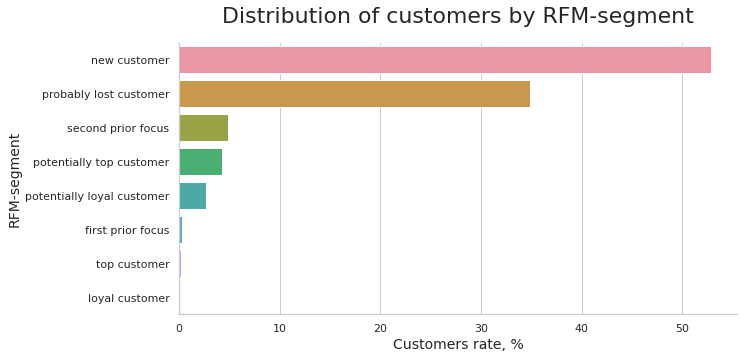

In [100]:
plt.figure(figsize=(10,5))

sns.barplot(data=customers_by_segment, y='description', x='customers_rate')            

plt.xlabel('Customers rate, %')
plt.ylabel('RFM-segment')
plt.title('Distribution of customers by RFM-segment')

sns.despine()
plt.show()

The distribution above shows that more than 50% of customers are new, and more than 30% are potentially lost.  
This may indicate that we sell goods that people rarely buy.

Let's give a more understandable and readable visualization.  
To do this, we should calculate the distribution of customers by segment type for each of the RFM metrics.

In [103]:
r_dist   = rfm.groupby('r_score', as_index=False).agg(r_customers=('Recency', 'count'))
f_dist   = rfm.groupby('f_score', as_index=False).agg(f_customers=('Frequency', 'count'))
m_dist   = rfm.groupby('m_score', as_index=False).agg(m_customers=('Monetary', 'count'))
rfm_dist = pd.concat([r_dist, f_dist, m_dist], axis=1)

Visualizing

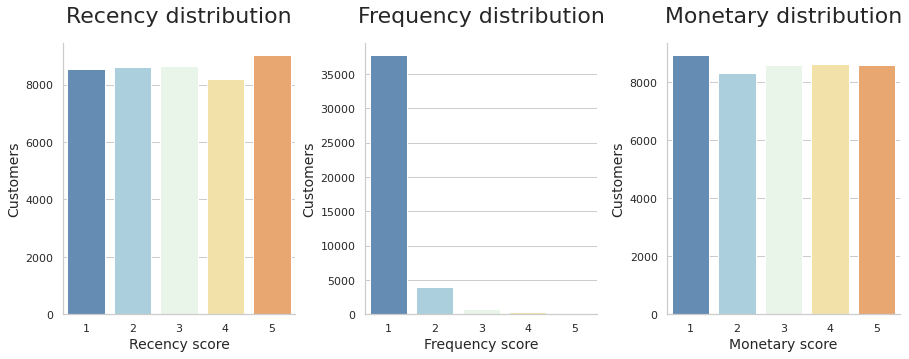

In [104]:
params    = ['Recency', 'Frequency', 'Monetary']
fig, axes = plt.subplots(nrows=1, ncols=metrics, figsize=(15, 5))

for i in range(metrics):
    ax     = axes[i]    
    column = i * 2
    
    sns.barplot(data=rfm_dist, x=rfm_dist.iloc[:, column], y=rfm_dist.iloc[:, column + 1], ax=ax)
        
    ax.set_title(f'{params[i]} distribution')           
    ax.set_xlabel(f'{params[i]} score') 
    ax.set_ylabel('Customers')       

sns.despine()
plt.subplots_adjust(wspace=0.3)            
plt.show()

Now the distribution of clients by groups for Recency and Monetary is much more even.  
This corresponds to the meaning of quantiles and suits RFM analysis much better.  
The distribution of customers by the Frequency metric is still heavily skewed to the left.  
However, nothing can be done about this as most of our customers have only made one purchase.